## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 
In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

# Formulation of a Rocket Landing problem


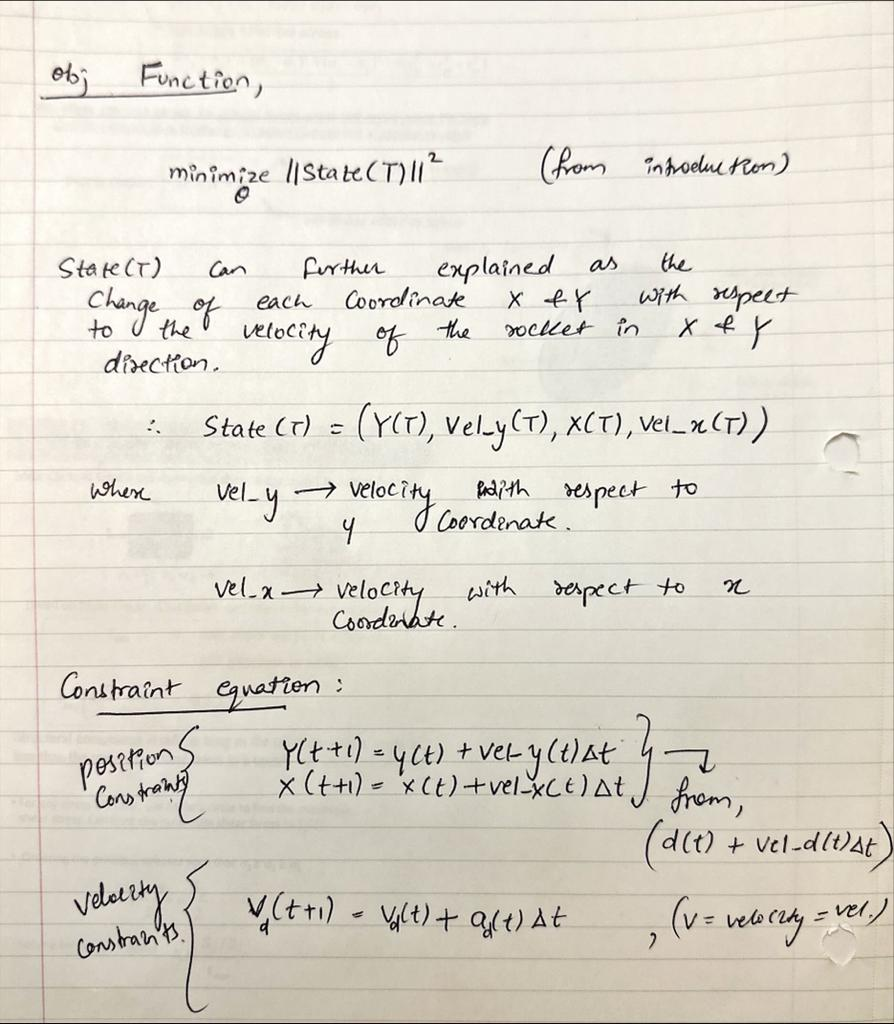

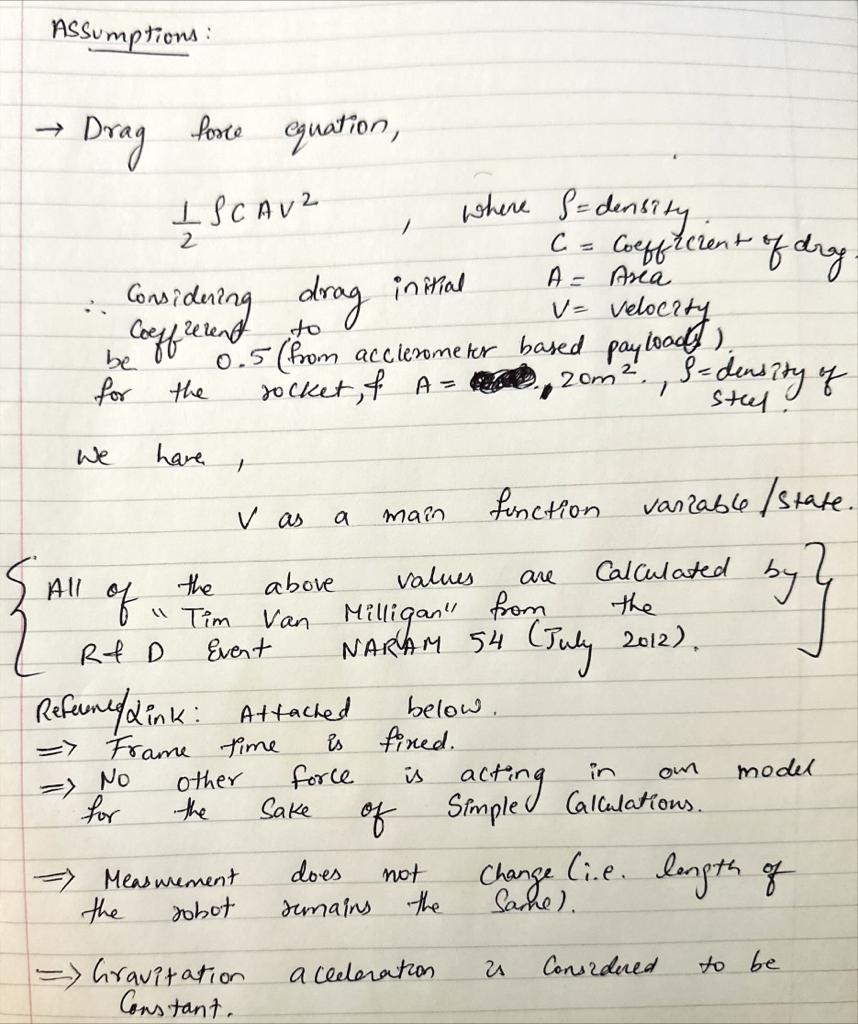

https://www.apogeerockets.com/downloads/Cd_determination_using_Coast_Data.pdf

In [44]:
import logging
from math import *
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [45]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

FRAME_TIME = 0.1  
#Area of rocket = 20 m^2
#Density of steel
Gravitation_acc = 9.80  
BOOST_acc = 15  
Drag = 0.005
#Rotational Accelaration = 100   #constant

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
       
        

        #defining state variables in tensor form
        delta_state_x = BOOST_acc * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  
        delta_state_y = BOOST_acc * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0] 
        
        #change in position due to drag
        Final = BOOST_acc - (Drag * delta_state_y*delta_state_y) #drag value is calculated by taking Cd, A and Rho value constant
        delta_state_y = Final * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        #delta_state_x = Final * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]
        #defining gravitaion force in tensor form
        delta_stateG = t.tensor([0., Gravitation_acc * FRAME_TIME, 0., 0.]) #Converting to 2D
        #change in motion due to drag
        state = state + delta_state_y + delta_stateG + delta_state_x
        matrix = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(matrix, state)
        return state


In [46]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [47]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        
        state = [4., 0., 1., -1.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [48]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.007)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        
        plt.subplot(222)
        plt.title('Distance X vs velocity X plot')
        plt.xlabel('DistanceX')
        plt.ylabel('VelocityX')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()
        
        plt.figure()
        plt.subplot(223)
        plt.title('Distance Y vs velocity Y plot')
        plt.xlabel('DistanceY')
        plt.ylabel('VelocityY')
        plt.plot(x, y)
        
        plt.subplot(221)
        plt.title('Distance X vs Distance Y plot')
        plt.xlabel('DistanceX')
        plt.ylabel('DistanceY')
        plt.plot(x, a)
        plt.tight_layout()
        plt.show()
        

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 109864.898


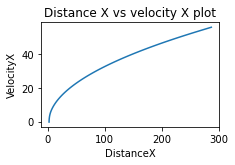

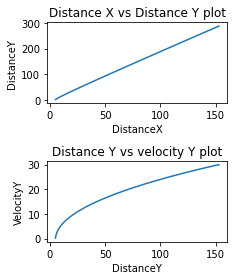

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 52056.160


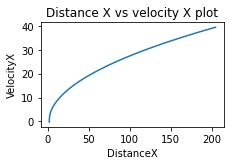

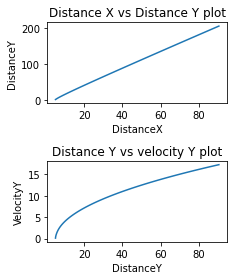

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 31652.195


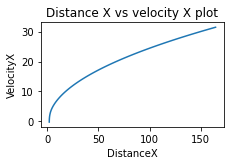

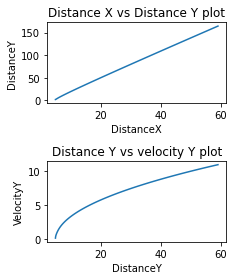

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 21755.527


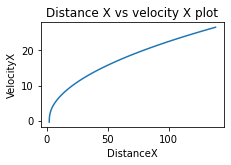

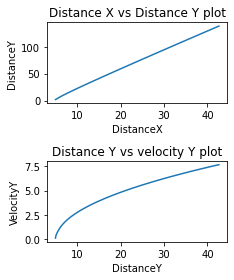

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 14241.678


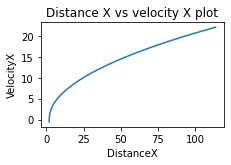

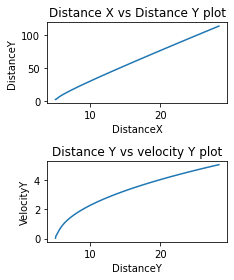

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 9047.675


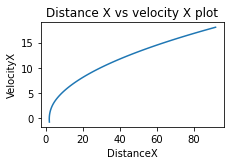

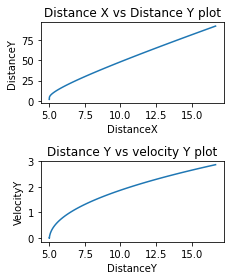

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 6310.218


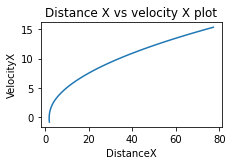

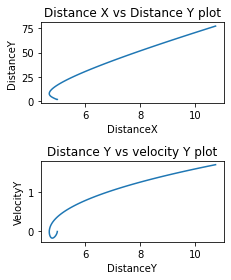

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 4627.561


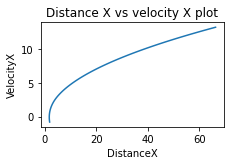

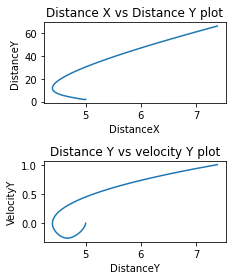

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 3511.732


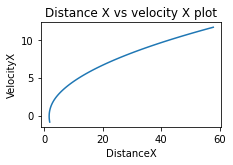

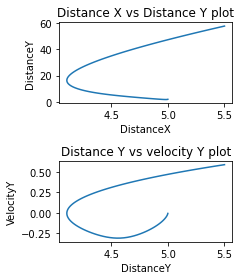

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 2735.909


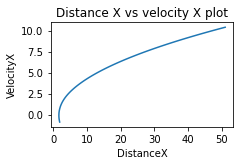

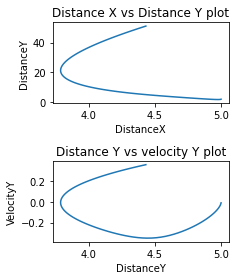

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 2103.689


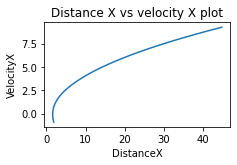

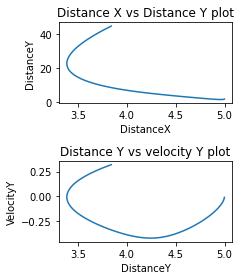

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 1383.748


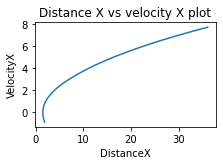

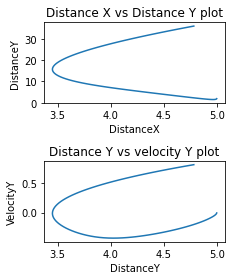

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 794.112


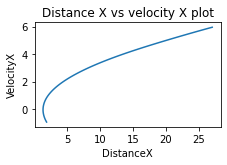

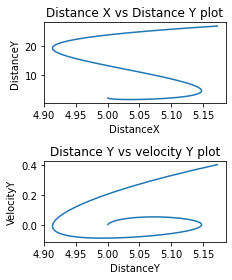

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 661.630


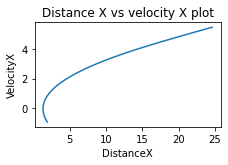

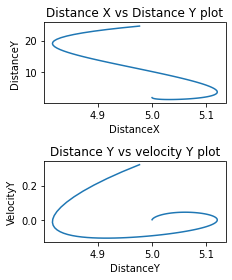

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 550.576


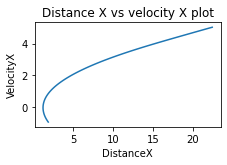

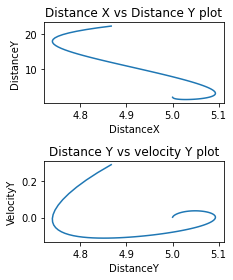

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 455.149


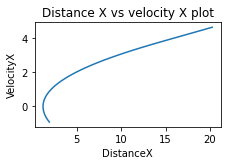

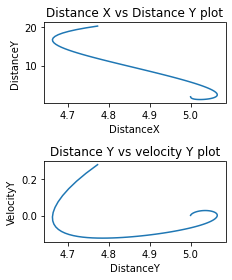

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 372.807


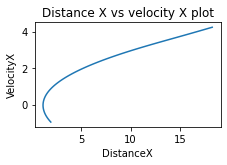

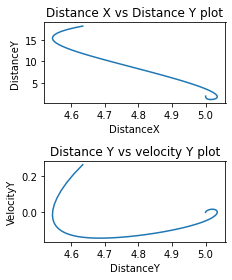

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 302.505


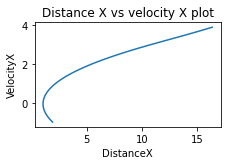

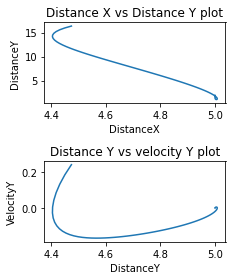

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 245.113


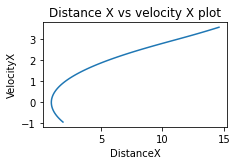

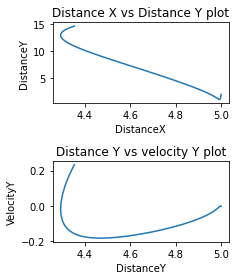

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 197.725


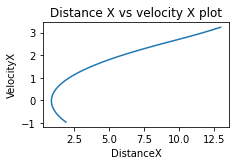

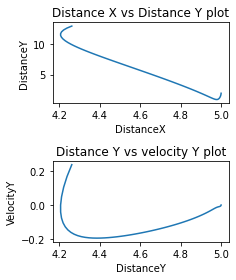

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 157.767


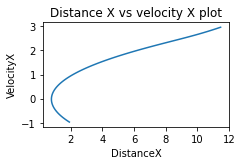

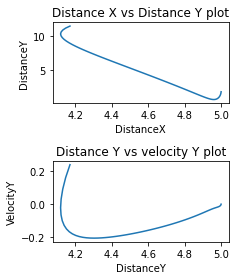

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 124.125


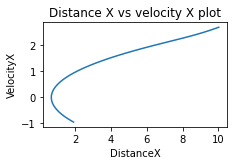

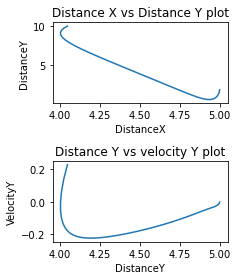

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 95.429


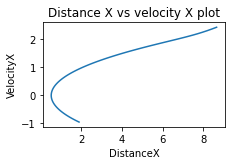

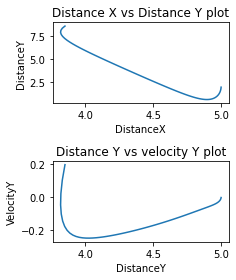

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 72.193


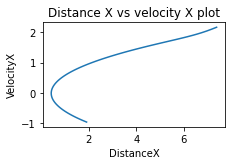

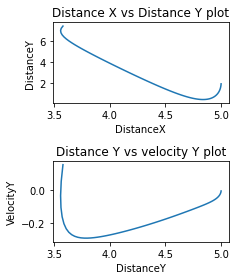

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 53.508


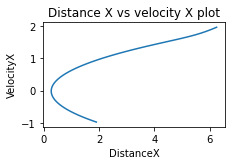

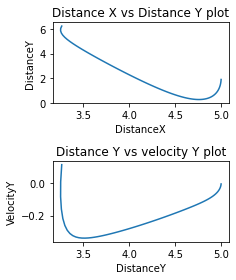

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 38.151


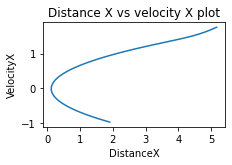

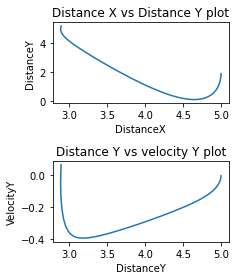

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 26.072


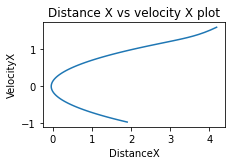

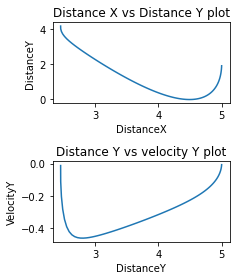

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 17.422


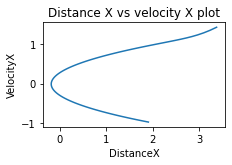

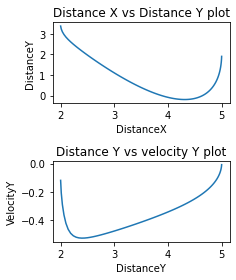

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 11.684


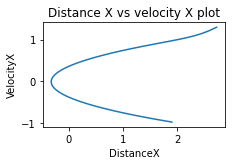

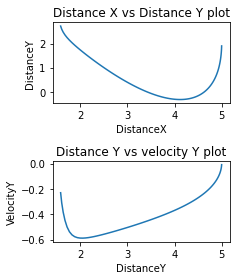

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 7.934


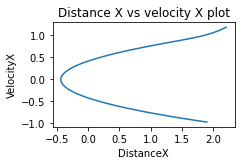

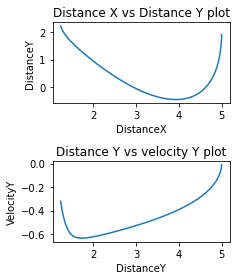

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 5.397


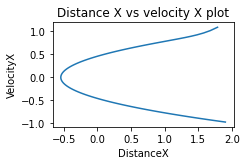

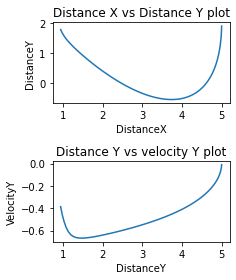

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 3.679


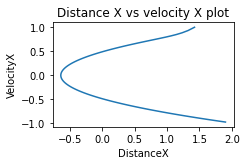

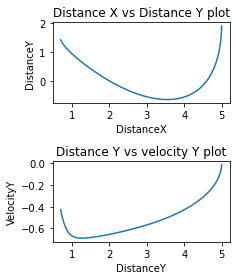

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 2.572


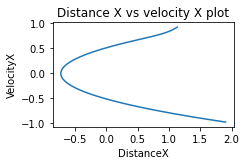

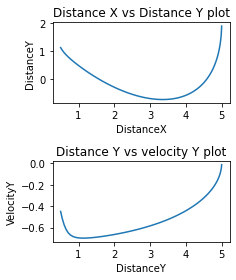

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 1.888


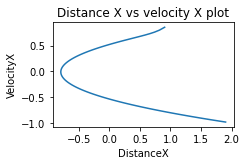

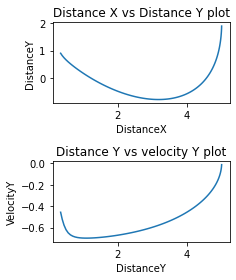

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 1.458


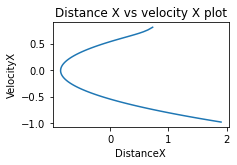

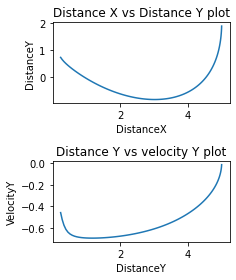

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 1.147


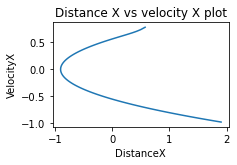

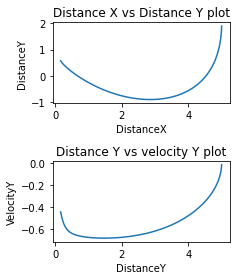

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.890


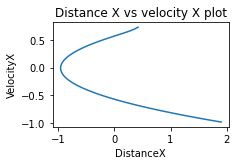

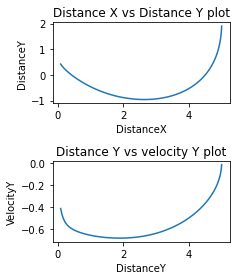

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.690


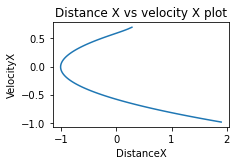

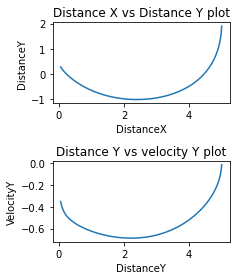

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.571


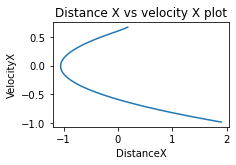

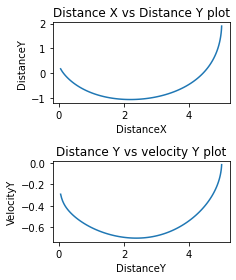

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.505


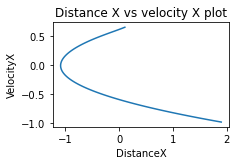

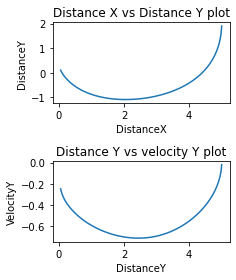

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.459


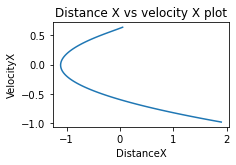

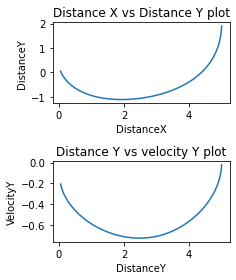

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.427


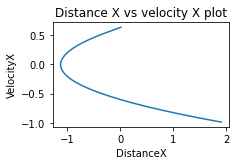

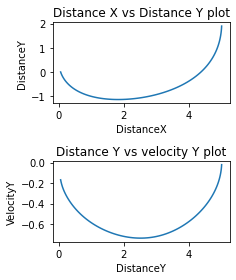

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.404


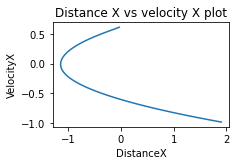

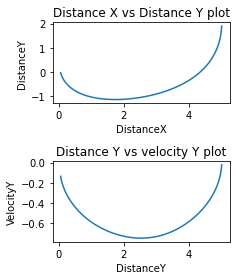

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.382


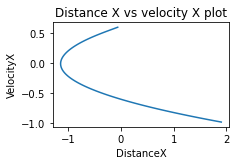

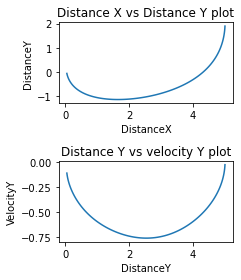

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.359


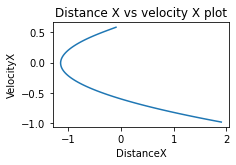

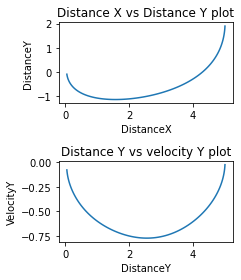

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.340


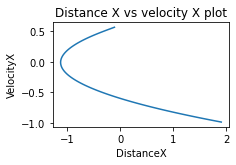

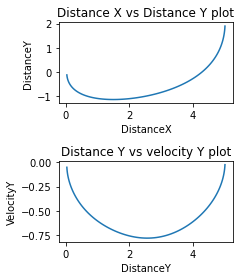

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.315


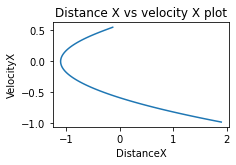

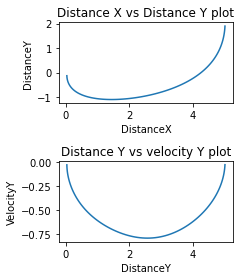

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.270


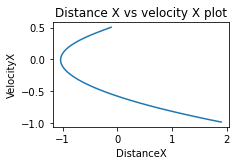

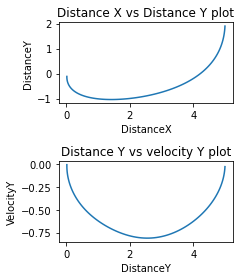

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.231


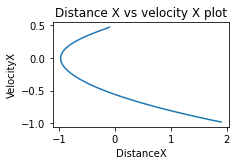

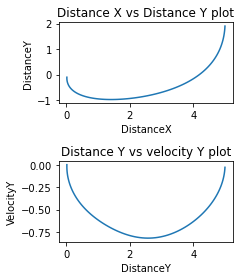

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.182


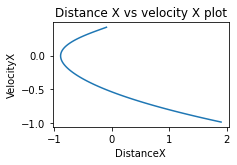

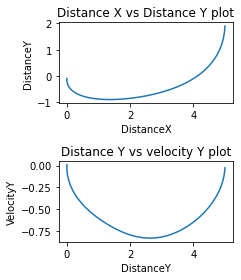

_______________________________________________________________________________________________________________

Iteration number:	 51
loss: 0.148


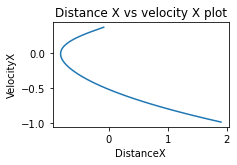

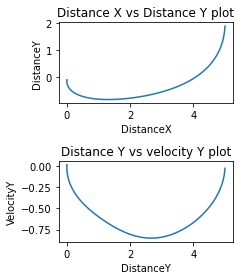

_______________________________________________________________________________________________________________

Iteration number:	 52
loss: 0.121


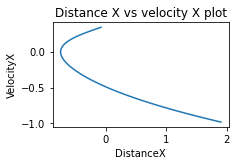

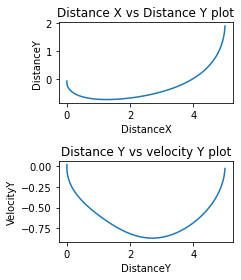

_______________________________________________________________________________________________________________

Iteration number:	 53
loss: 0.099


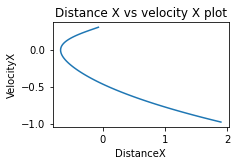

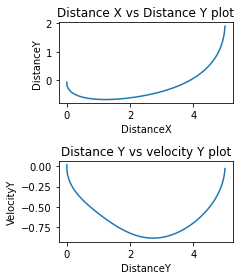

_______________________________________________________________________________________________________________

Iteration number:	 54
loss: 0.081


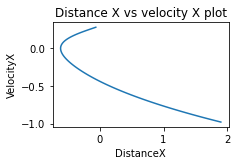

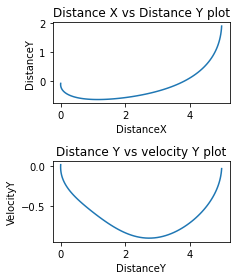

_______________________________________________________________________________________________________________

Iteration number:	 55
loss: 0.066


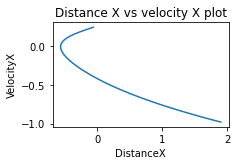

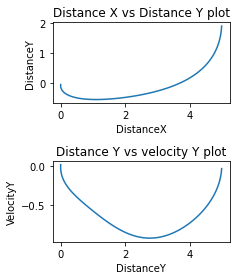

_______________________________________________________________________________________________________________

Iteration number:	 56
loss: 0.054


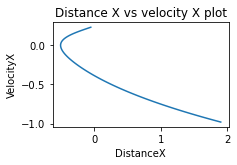

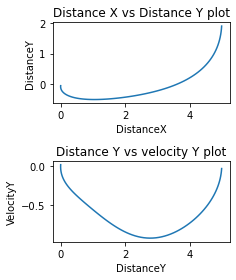

_______________________________________________________________________________________________________________

Iteration number:	 57
loss: 0.044


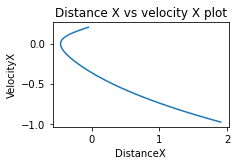

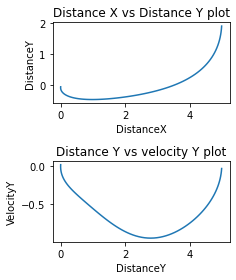

_______________________________________________________________________________________________________________

Iteration number:	 58
loss: 0.036


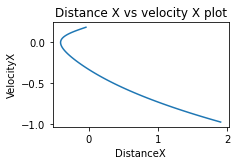

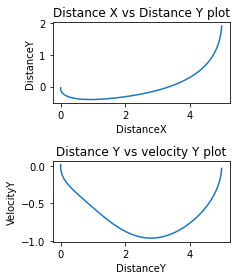

_______________________________________________________________________________________________________________

Iteration number:	 59
loss: 0.029


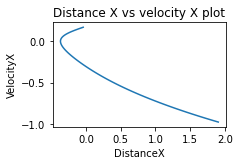

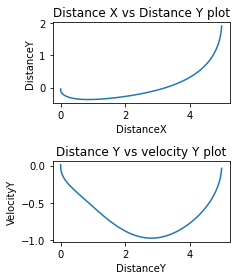

_______________________________________________________________________________________________________________

Iteration number:	 60
loss: 0.024


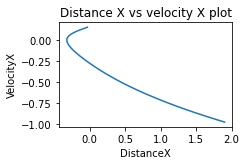

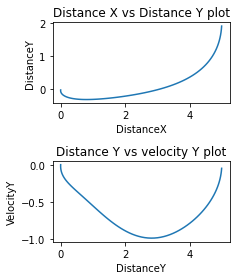

_______________________________________________________________________________________________________________

Iteration number:	 61
loss: 0.019


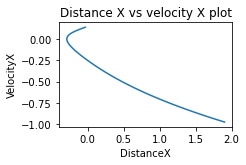

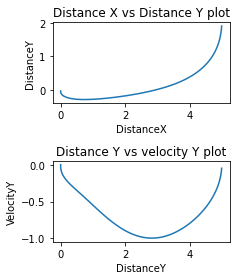

_______________________________________________________________________________________________________________

Iteration number:	 62
loss: 0.016


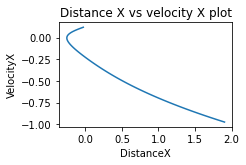

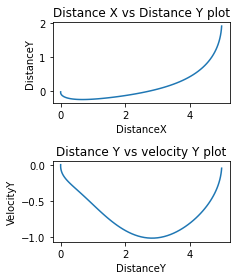

_______________________________________________________________________________________________________________

Iteration number:	 63
loss: 0.013


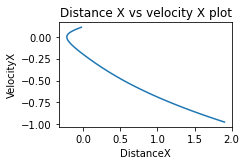

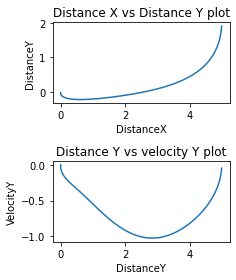

_______________________________________________________________________________________________________________

Iteration number:	 64
loss: 0.010


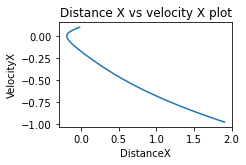

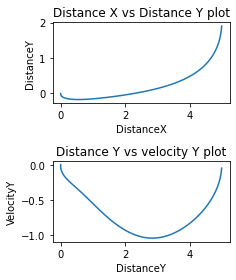

_______________________________________________________________________________________________________________

Iteration number:	 65
loss: 0.008


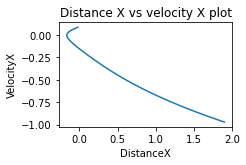

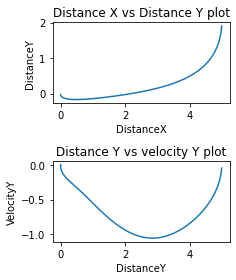

_______________________________________________________________________________________________________________

Iteration number:	 66
loss: 0.007


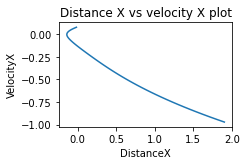

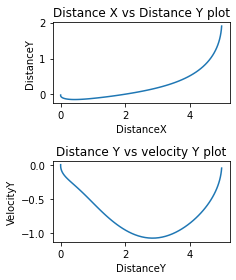

_______________________________________________________________________________________________________________

Iteration number:	 67
loss: 0.005


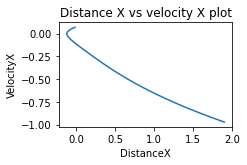

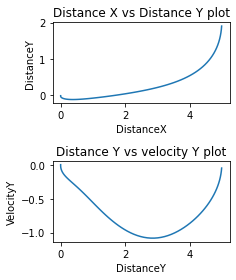

_______________________________________________________________________________________________________________

Iteration number:	 68
loss: 0.004


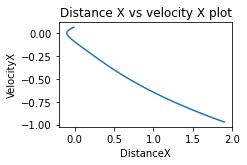

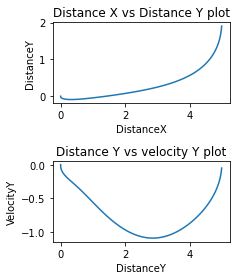

_______________________________________________________________________________________________________________

Iteration number:	 69
loss: 0.003


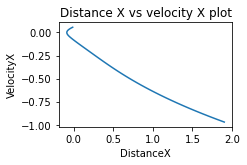

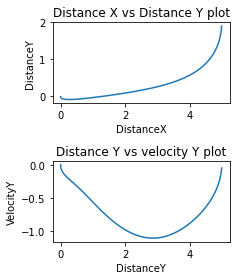

_______________________________________________________________________________________________________________

Iteration number:	 70
loss: 0.003


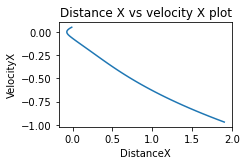

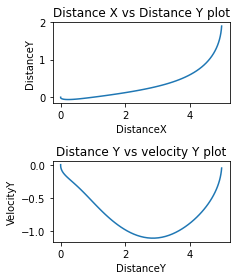

_______________________________________________________________________________________________________________

Iteration number:	 71
loss: 0.002


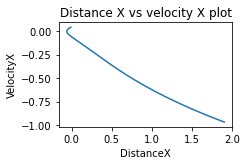

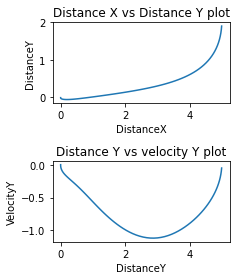

_______________________________________________________________________________________________________________

Iteration number:	 72
loss: 0.002


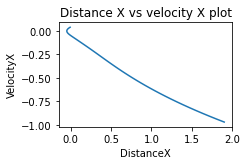

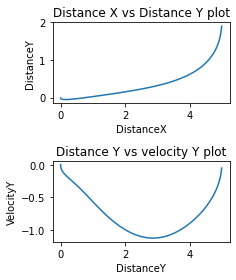

_______________________________________________________________________________________________________________

Iteration number:	 73
loss: 0.001


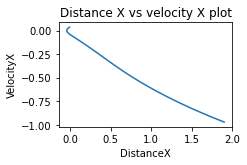

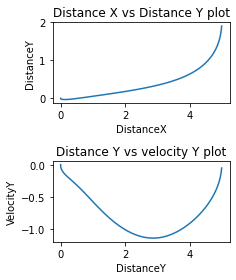

_______________________________________________________________________________________________________________

Iteration number:	 74
loss: 0.001


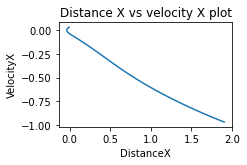

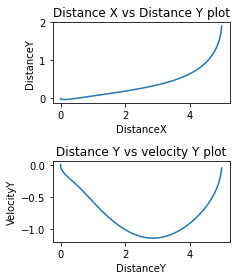

_______________________________________________________________________________________________________________

Iteration number:	 75
loss: 0.001


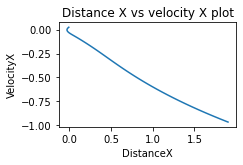

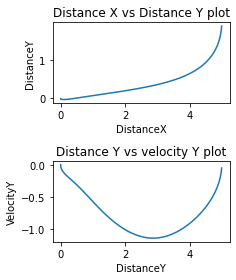

_______________________________________________________________________________________________________________

Iteration number:	 76
loss: 0.001


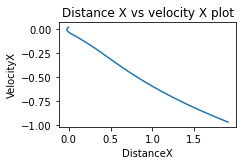

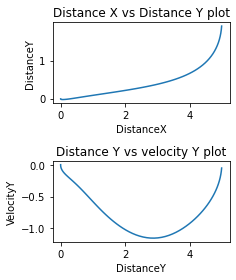

_______________________________________________________________________________________________________________

Iteration number:	 77
loss: 0.000


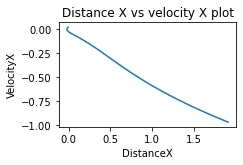

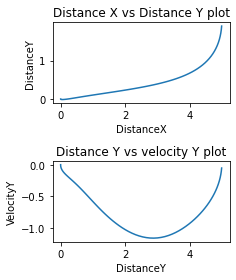

_______________________________________________________________________________________________________________

Iteration number:	 78
loss: 0.000


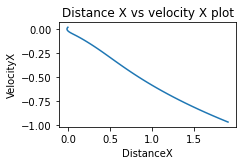

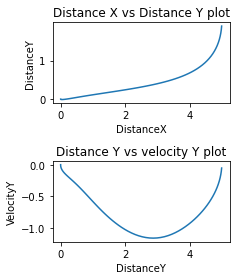

_______________________________________________________________________________________________________________

Iteration number:	 79
loss: 0.000


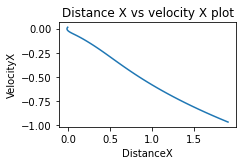

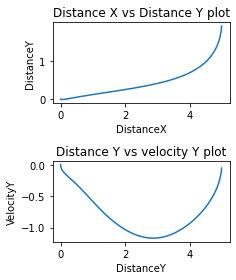

_______________________________________________________________________________________________________________

Iteration number:	 80
loss: 0.000


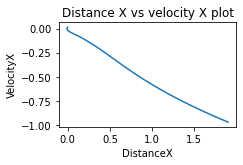

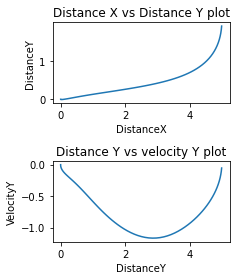

_______________________________________________________________________________________________________________

Iteration number:	 81
loss: 0.000


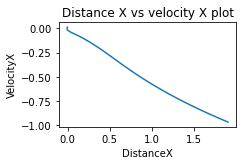

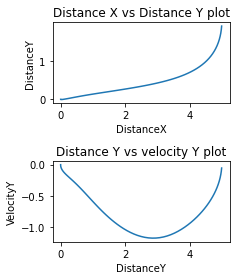

_______________________________________________________________________________________________________________

Iteration number:	 82
loss: 0.000


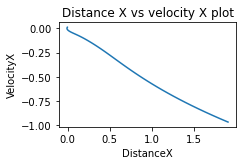

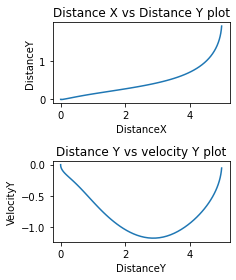

_______________________________________________________________________________________________________________

Iteration number:	 83
loss: 0.000


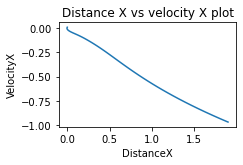

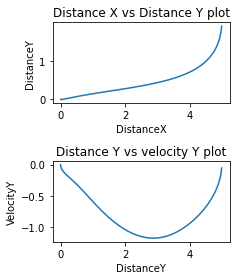

_______________________________________________________________________________________________________________

Iteration number:	 84
loss: 0.000


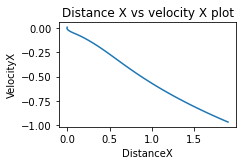

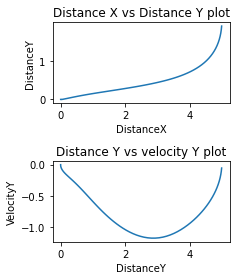

_______________________________________________________________________________________________________________

Iteration number:	 85
loss: 0.000


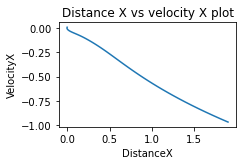

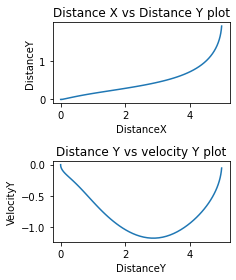

_______________________________________________________________________________________________________________

Iteration number:	 86
loss: 0.000


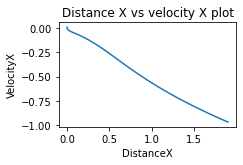

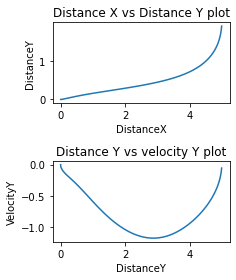

_______________________________________________________________________________________________________________

Iteration number:	 87
loss: 0.000


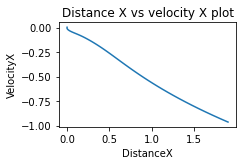

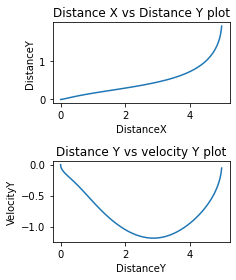

_______________________________________________________________________________________________________________

Iteration number:	 88
loss: 0.000


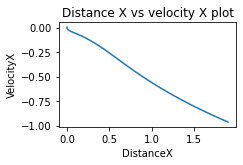

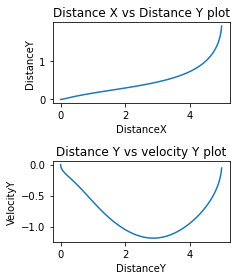

_______________________________________________________________________________________________________________

Iteration number:	 89
loss: 0.000


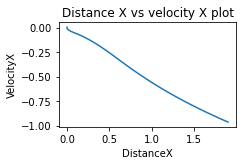

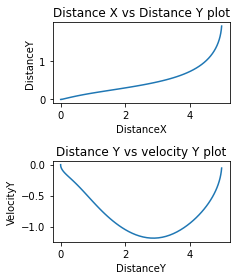

_______________________________________________________________________________________________________________

Iteration number:	 90
loss: 0.000


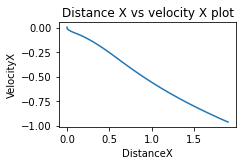

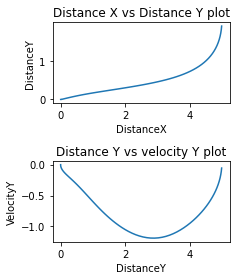

_______________________________________________________________________________________________________________

Iteration number:	 91
loss: 0.000


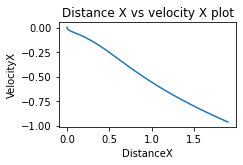

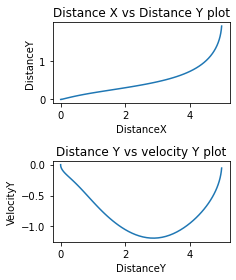

_______________________________________________________________________________________________________________

Iteration number:	 92
loss: 0.000


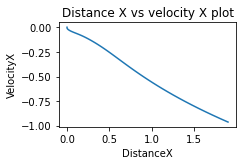

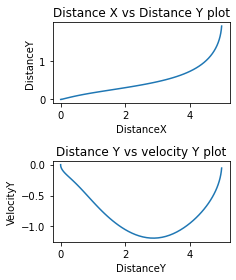

_______________________________________________________________________________________________________________

Iteration number:	 93
loss: 0.000


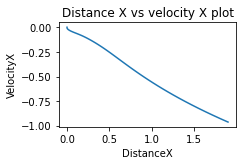

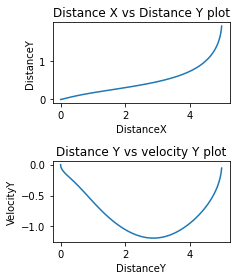

_______________________________________________________________________________________________________________

Iteration number:	 94
loss: 0.000


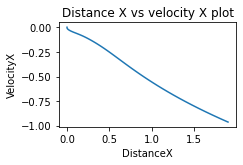

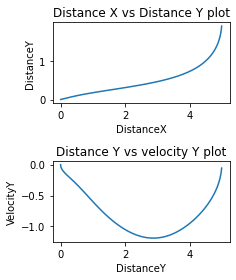

_______________________________________________________________________________________________________________

Iteration number:	 95
loss: 0.000


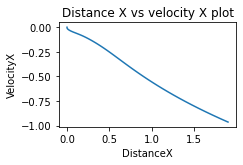

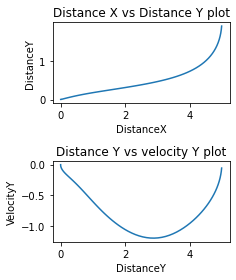

_______________________________________________________________________________________________________________

Iteration number:	 96
loss: 0.000


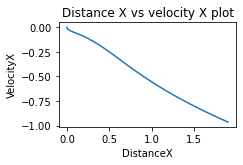

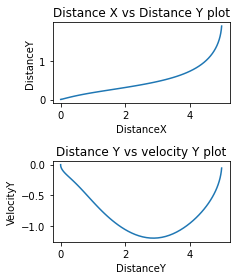

_______________________________________________________________________________________________________________

Iteration number:	 97
loss: 0.000


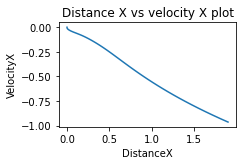

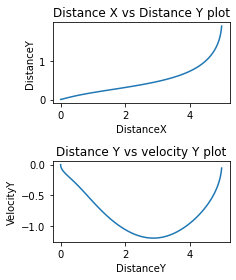

_______________________________________________________________________________________________________________

Iteration number:	 98
loss: 0.000


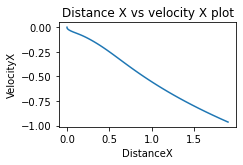

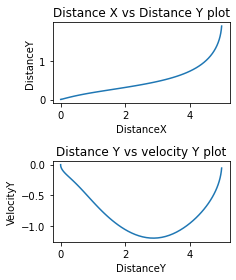

_______________________________________________________________________________________________________________

Iteration number:	 99
loss: 0.000


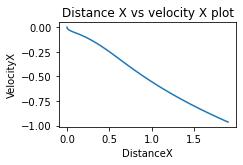

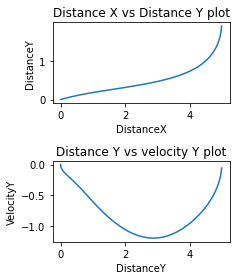

_______________________________________________________________________________________________________________

Iteration number:	 100
loss: 0.000


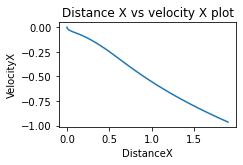

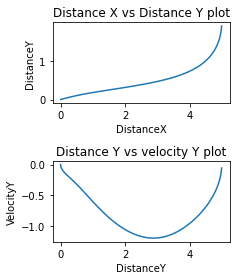

_______________________________________________________________________________________________________________

Iteration number:	 101
loss: 0.000


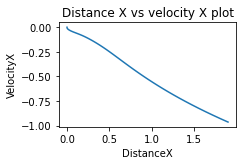

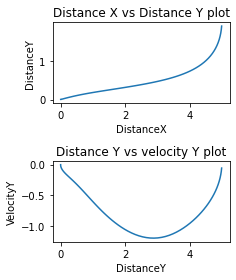

_______________________________________________________________________________________________________________

Iteration number:	 102
loss: 0.000


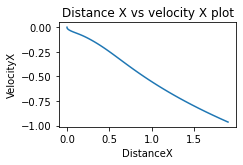

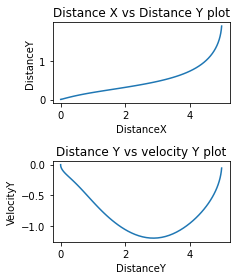

_______________________________________________________________________________________________________________

Iteration number:	 103
loss: 0.000


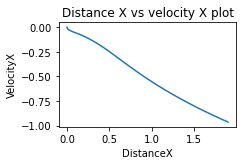

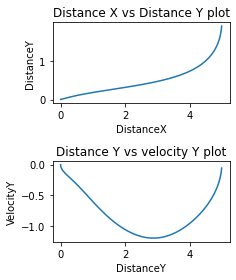

_______________________________________________________________________________________________________________

Iteration number:	 104
loss: 0.000


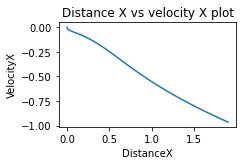

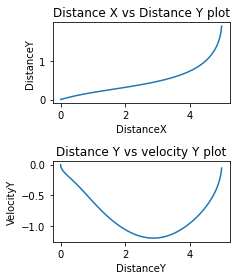

_______________________________________________________________________________________________________________

Iteration number:	 105
loss: 0.000


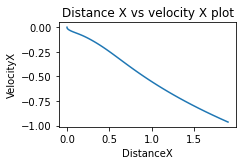

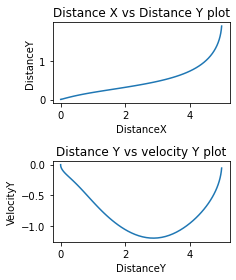

_______________________________________________________________________________________________________________

Iteration number:	 106
loss: 0.000


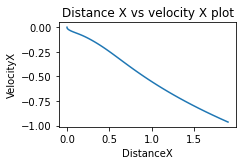

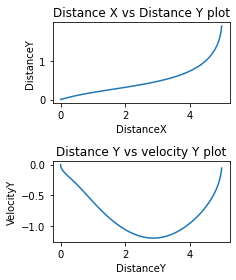

_______________________________________________________________________________________________________________

Iteration number:	 107
loss: 0.000


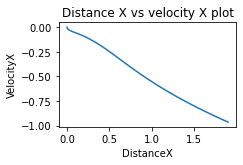

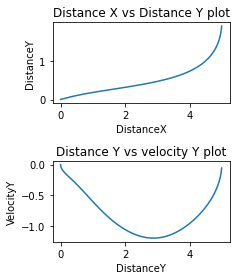

_______________________________________________________________________________________________________________

Iteration number:	 108
loss: 0.000


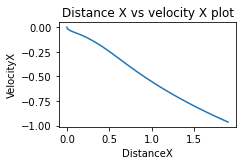

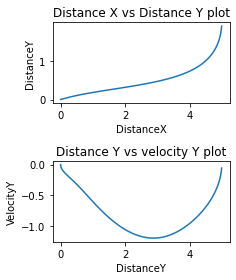

_______________________________________________________________________________________________________________

Iteration number:	 109
loss: 0.000


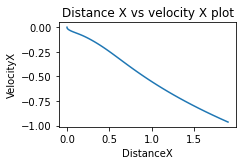

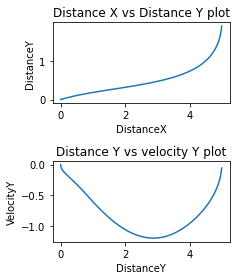

_______________________________________________________________________________________________________________

Iteration number:	 110
loss: 0.000


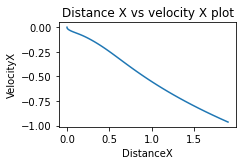

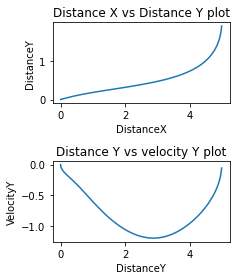

_______________________________________________________________________________________________________________

Iteration number:	 111
loss: 0.000


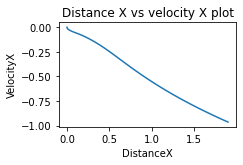

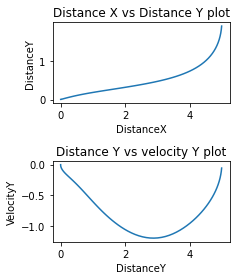

_______________________________________________________________________________________________________________

Iteration number:	 112
loss: 0.000


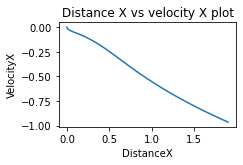

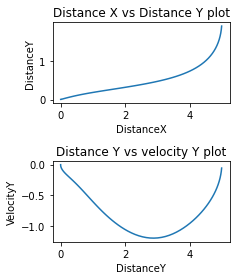

_______________________________________________________________________________________________________________

Iteration number:	 113
loss: 0.000


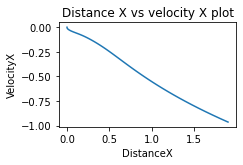

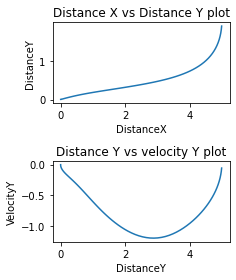

_______________________________________________________________________________________________________________

Iteration number:	 114
loss: 0.000


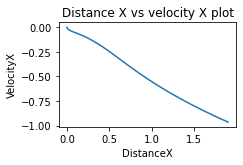

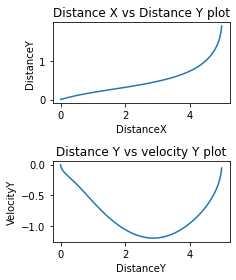

_______________________________________________________________________________________________________________

Iteration number:	 115
loss: 0.000


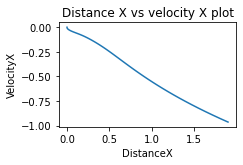

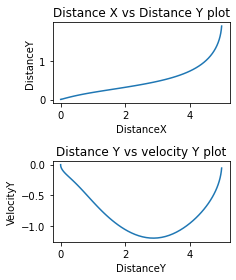

_______________________________________________________________________________________________________________

Iteration number:	 116
loss: 0.000


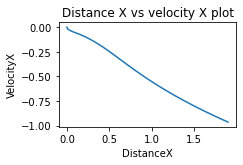

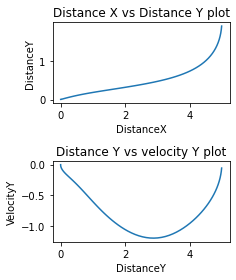

_______________________________________________________________________________________________________________

Iteration number:	 117
loss: 0.000


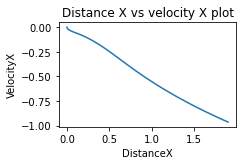

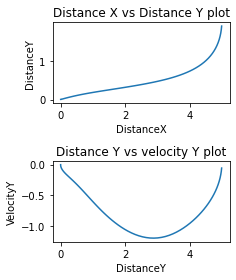

_______________________________________________________________________________________________________________

Iteration number:	 118
loss: 0.000


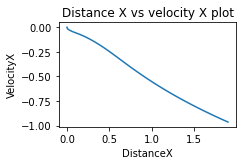

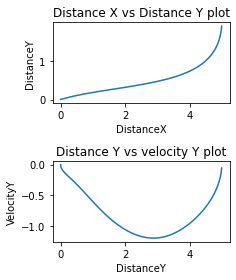

_______________________________________________________________________________________________________________

Iteration number:	 119
loss: 0.000


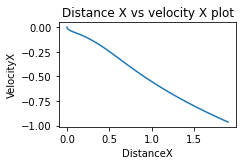

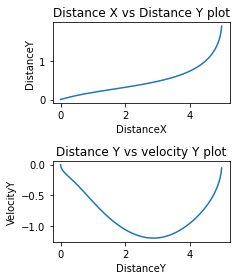

_______________________________________________________________________________________________________________

Iteration number:	 120
loss: 0.000


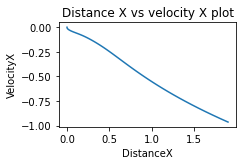

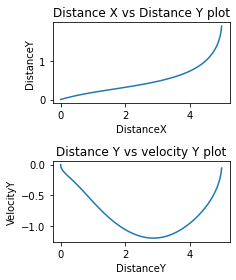

_______________________________________________________________________________________________________________

Iteration number:	 121
loss: 0.000


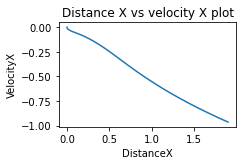

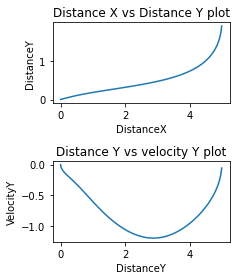

_______________________________________________________________________________________________________________

Iteration number:	 122
loss: 0.000


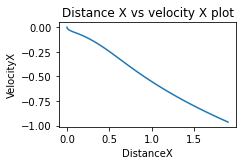

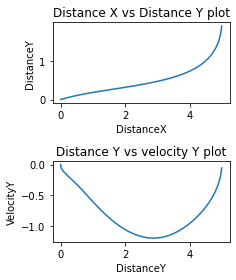

_______________________________________________________________________________________________________________

Iteration number:	 123
loss: 0.000


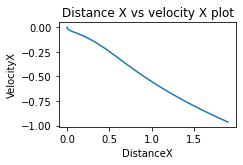

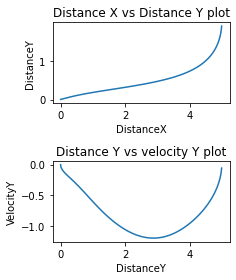

_______________________________________________________________________________________________________________

Iteration number:	 124
loss: 0.000


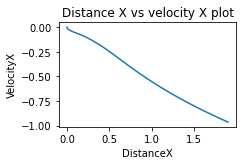

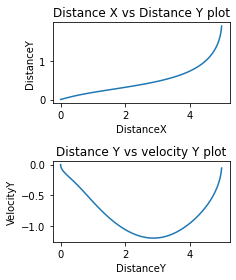

_______________________________________________________________________________________________________________

Iteration number:	 125
loss: 0.000


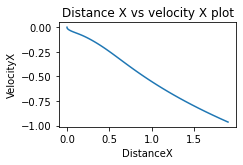

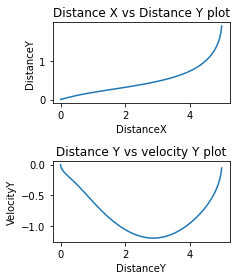

_______________________________________________________________________________________________________________

Iteration number:	 126
loss: 0.000


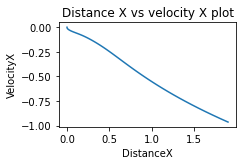

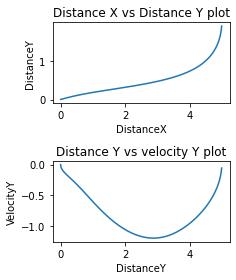

_______________________________________________________________________________________________________________

Iteration number:	 127
loss: 0.000


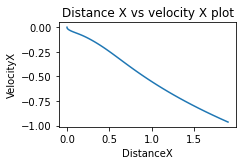

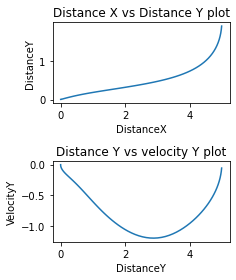

_______________________________________________________________________________________________________________

Iteration number:	 128
loss: 0.000


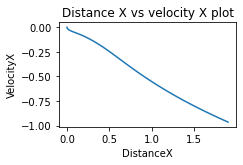

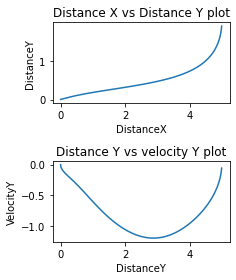

_______________________________________________________________________________________________________________

Iteration number:	 129
loss: 0.000


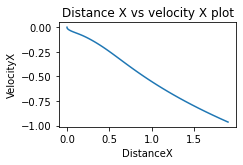

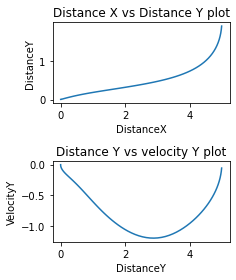

_______________________________________________________________________________________________________________

Iteration number:	 130
loss: 0.000


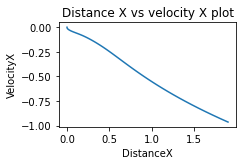

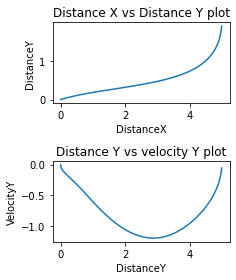

_______________________________________________________________________________________________________________

Iteration number:	 131
loss: 0.000


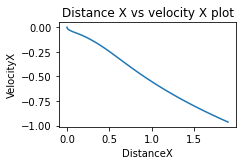

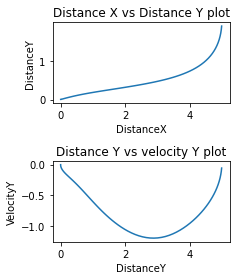

_______________________________________________________________________________________________________________

Iteration number:	 132
loss: 0.000


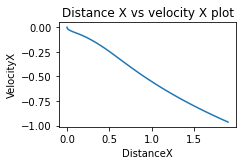

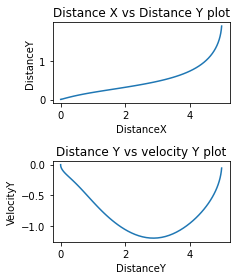

_______________________________________________________________________________________________________________

Iteration number:	 133
loss: 0.000


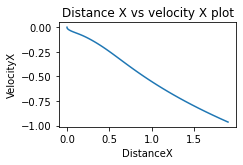

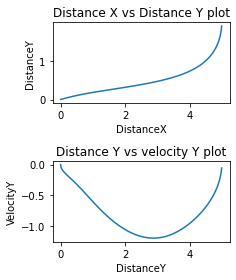

_______________________________________________________________________________________________________________

Iteration number:	 134
loss: 0.000


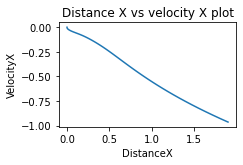

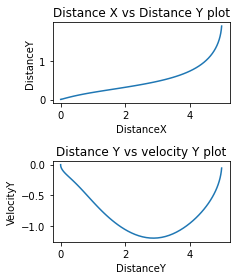

_______________________________________________________________________________________________________________

Iteration number:	 135
loss: 0.000


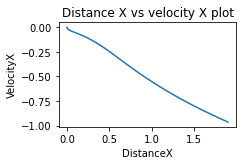

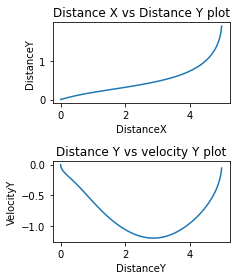

_______________________________________________________________________________________________________________

Iteration number:	 136
loss: 0.000


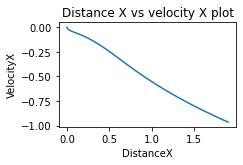

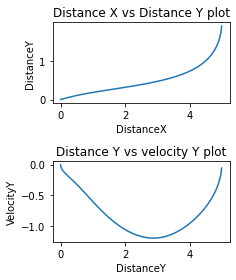

_______________________________________________________________________________________________________________

Iteration number:	 137
loss: 0.000


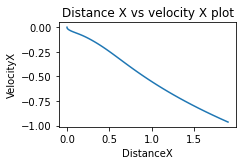

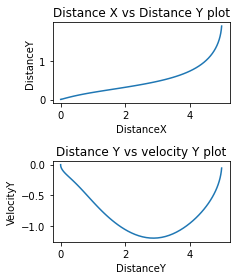

_______________________________________________________________________________________________________________

Iteration number:	 138
loss: 0.000


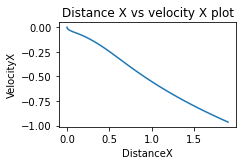

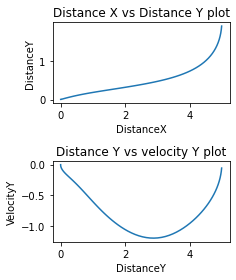

_______________________________________________________________________________________________________________

Iteration number:	 139
loss: 0.000


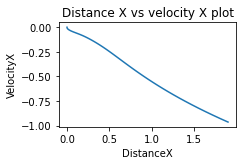

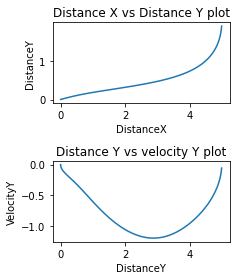

_______________________________________________________________________________________________________________

Iteration number:	 140
loss: 0.000


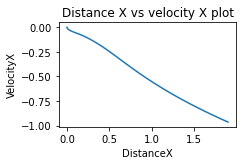

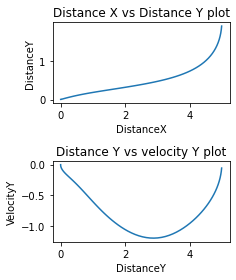

_______________________________________________________________________________________________________________

Iteration number:	 141
loss: 0.000


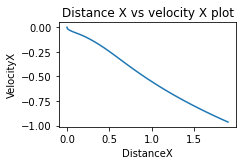

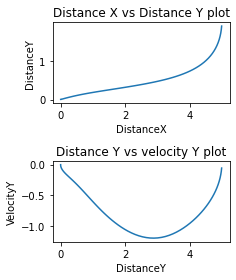

_______________________________________________________________________________________________________________

Iteration number:	 142
loss: 0.000


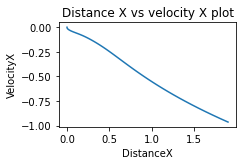

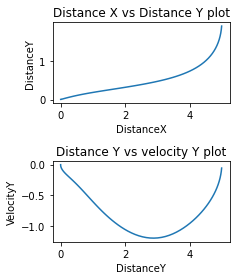

_______________________________________________________________________________________________________________

Iteration number:	 143
loss: 0.000


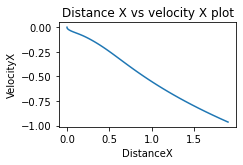

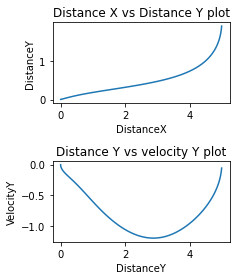

_______________________________________________________________________________________________________________

Iteration number:	 144
loss: 0.000


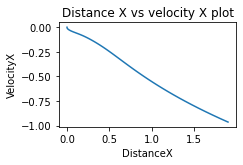

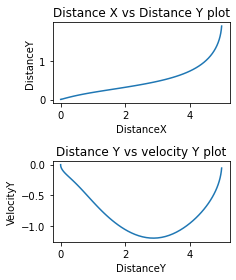

_______________________________________________________________________________________________________________

Iteration number:	 145
loss: 0.000


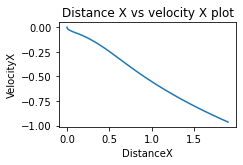

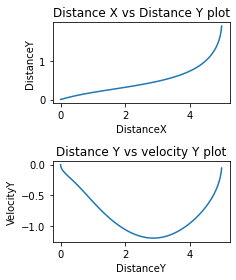

_______________________________________________________________________________________________________________

Iteration number:	 146
loss: 0.000


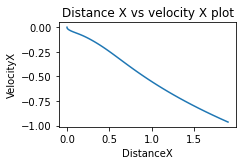

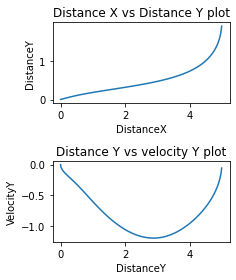

_______________________________________________________________________________________________________________

Iteration number:	 147
loss: 0.000


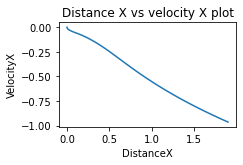

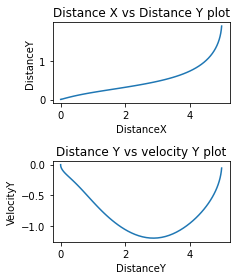

_______________________________________________________________________________________________________________

Iteration number:	 148
loss: 0.000


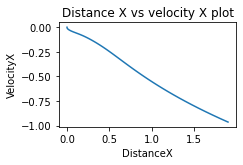

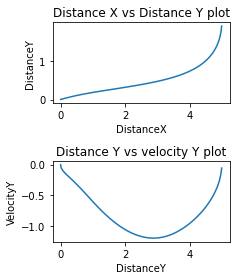

_______________________________________________________________________________________________________________

Iteration number:	 149
loss: 0.000


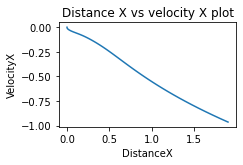

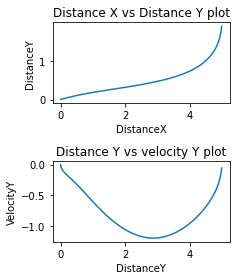

_______________________________________________________________________________________________________________

Iteration number:	 150
loss: 0.000


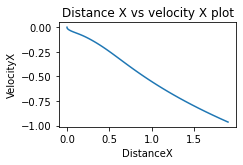

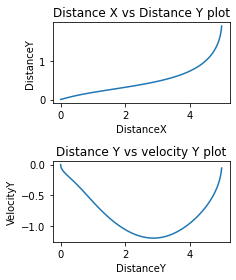

_______________________________________________________________________________________________________________

Iteration number:	 151
loss: 0.000


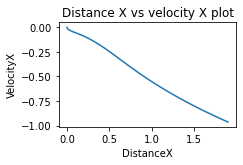

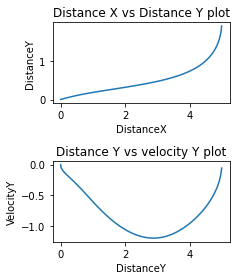

_______________________________________________________________________________________________________________

Iteration number:	 152
loss: 0.000


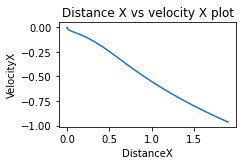

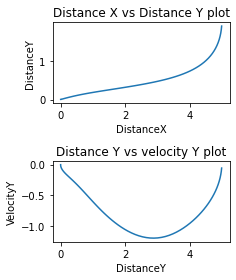

_______________________________________________________________________________________________________________

Iteration number:	 153
loss: 0.000


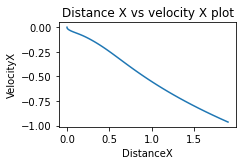

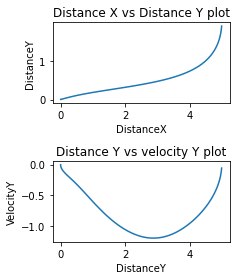

_______________________________________________________________________________________________________________

Iteration number:	 154
loss: 0.000


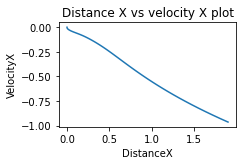

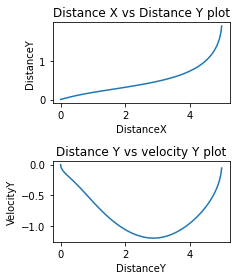

_______________________________________________________________________________________________________________

Iteration number:	 155
loss: 0.000


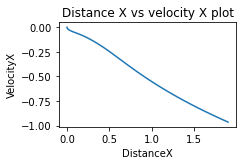

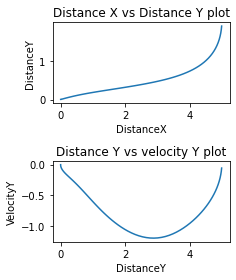

_______________________________________________________________________________________________________________

Iteration number:	 156
loss: 0.000


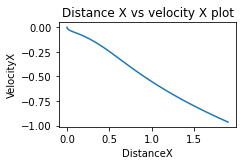

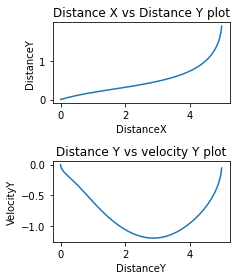

_______________________________________________________________________________________________________________

Iteration number:	 157
loss: 0.000


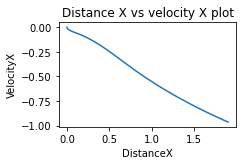

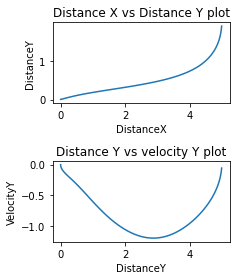

_______________________________________________________________________________________________________________

Iteration number:	 158
loss: 0.000


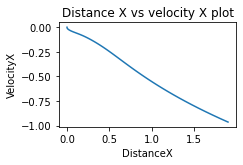

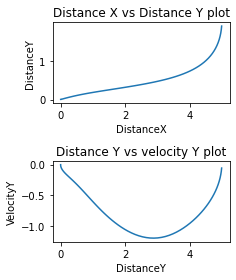

_______________________________________________________________________________________________________________

Iteration number:	 159
loss: 0.000


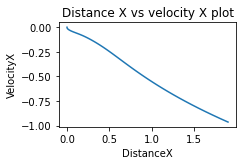

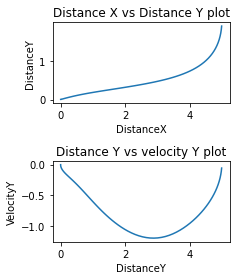

_______________________________________________________________________________________________________________

Iteration number:	 160
loss: 0.000


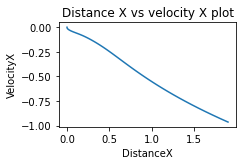

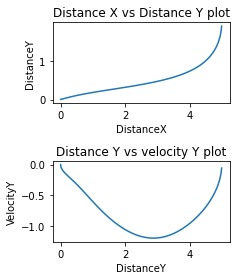

_______________________________________________________________________________________________________________

Iteration number:	 161
loss: 0.000


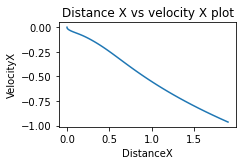

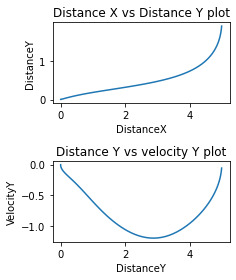

_______________________________________________________________________________________________________________

Iteration number:	 162
loss: 0.000


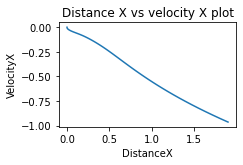

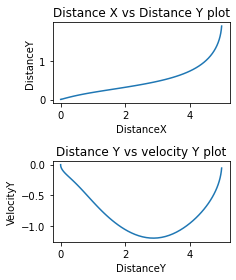

_______________________________________________________________________________________________________________

Iteration number:	 163
loss: 0.000


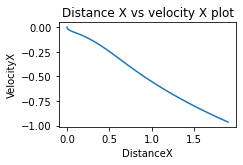

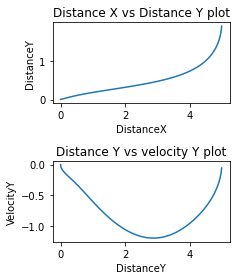

_______________________________________________________________________________________________________________

Iteration number:	 164
loss: 0.000


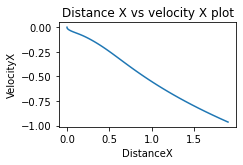

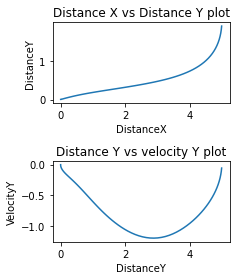

_______________________________________________________________________________________________________________

Iteration number:	 165
loss: 0.000


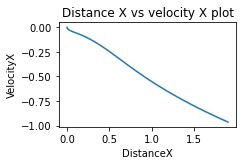

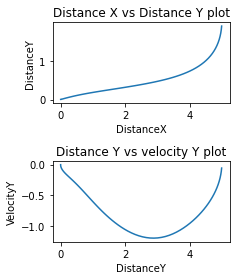

_______________________________________________________________________________________________________________

Iteration number:	 166
loss: 0.000


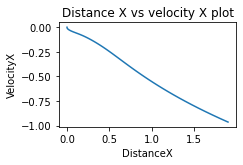

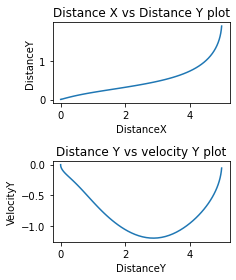

_______________________________________________________________________________________________________________

Iteration number:	 167
loss: 0.000


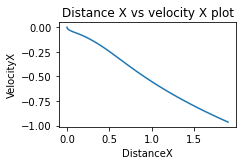

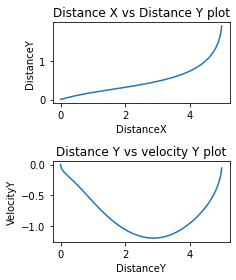

_______________________________________________________________________________________________________________

Iteration number:	 168
loss: 0.000


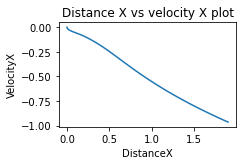

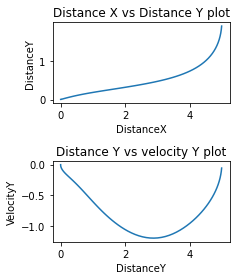

_______________________________________________________________________________________________________________

Iteration number:	 169
loss: 0.000


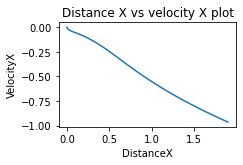

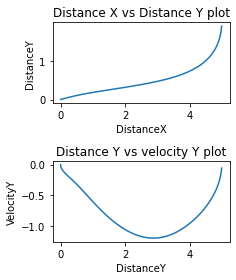

_______________________________________________________________________________________________________________

Iteration number:	 170
loss: 0.000


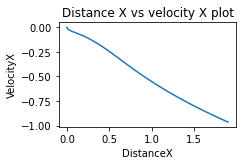

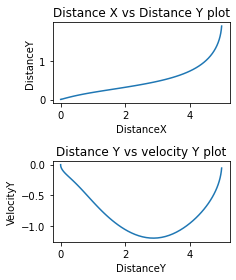

_______________________________________________________________________________________________________________

Iteration number:	 171
loss: 0.000


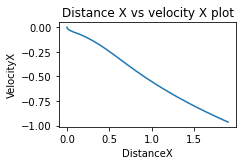

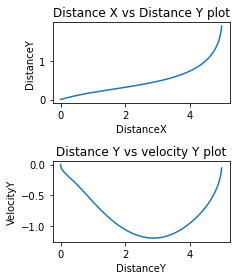

_______________________________________________________________________________________________________________

Iteration number:	 172
loss: 0.000


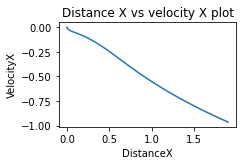

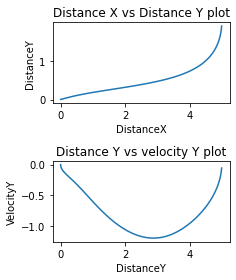

_______________________________________________________________________________________________________________

Iteration number:	 173
loss: 0.000


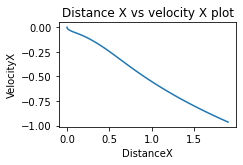

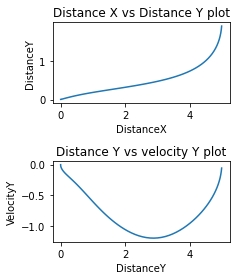

_______________________________________________________________________________________________________________

Iteration number:	 174
loss: 0.000


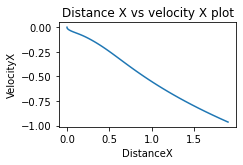

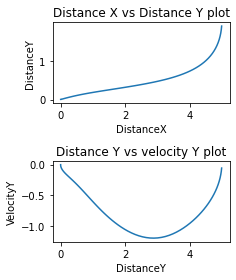

_______________________________________________________________________________________________________________

Iteration number:	 175
loss: 0.000


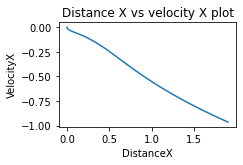

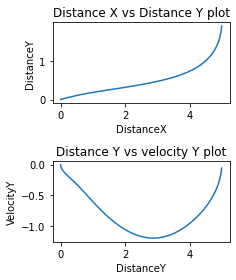

_______________________________________________________________________________________________________________

Iteration number:	 176
loss: 0.000


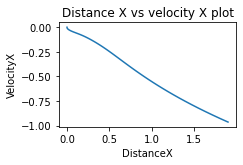

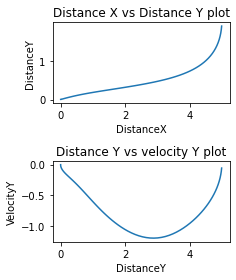

_______________________________________________________________________________________________________________

Iteration number:	 177
loss: 0.000


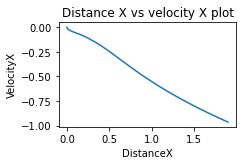

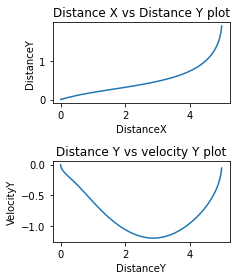

_______________________________________________________________________________________________________________

Iteration number:	 178
loss: 0.000


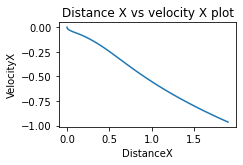

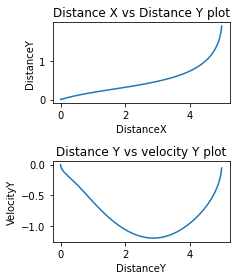

_______________________________________________________________________________________________________________

Iteration number:	 179
loss: 0.000


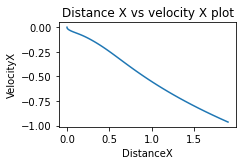

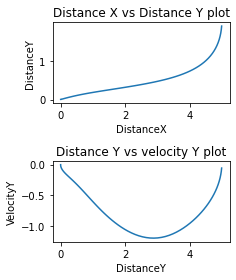

_______________________________________________________________________________________________________________

Iteration number:	 180
loss: 0.000


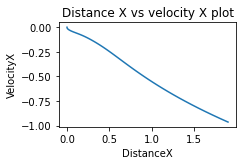

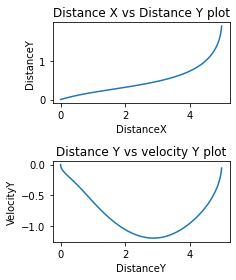

_______________________________________________________________________________________________________________

Iteration number:	 181
loss: 0.000


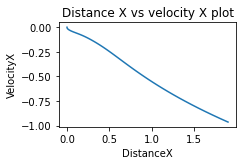

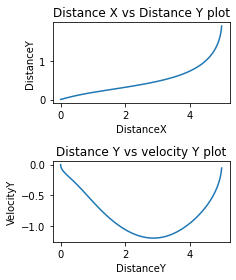

_______________________________________________________________________________________________________________

Iteration number:	 182
loss: 0.000


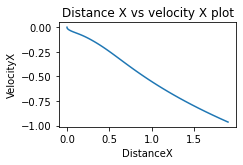

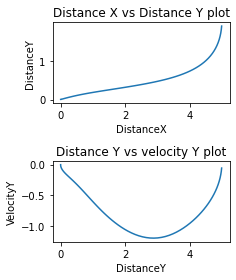

_______________________________________________________________________________________________________________

Iteration number:	 183
loss: 0.000


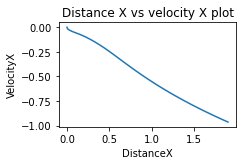

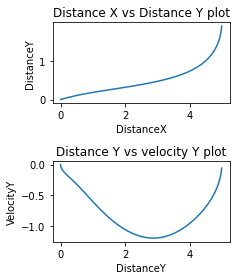

_______________________________________________________________________________________________________________

Iteration number:	 184
loss: 0.000


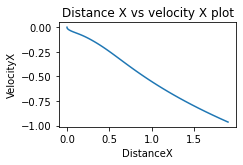

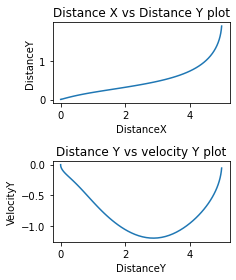

_______________________________________________________________________________________________________________

Iteration number:	 185
loss: 0.000


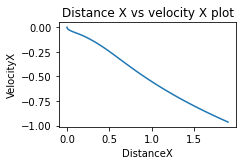

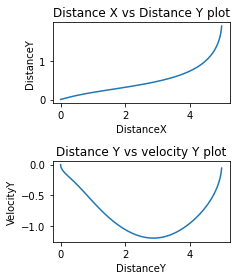

_______________________________________________________________________________________________________________

Iteration number:	 186
loss: 0.000


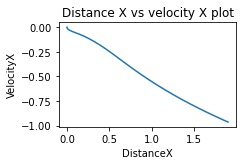

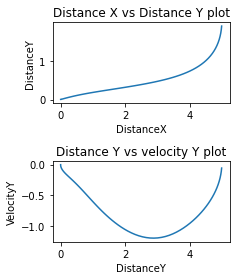

_______________________________________________________________________________________________________________

Iteration number:	 187
loss: 0.000


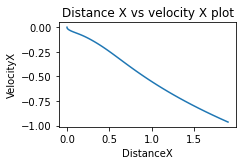

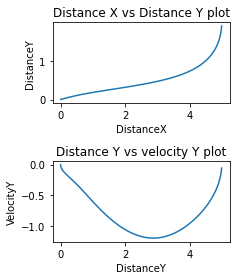

_______________________________________________________________________________________________________________

Iteration number:	 188
loss: 0.000


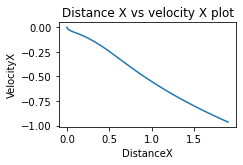

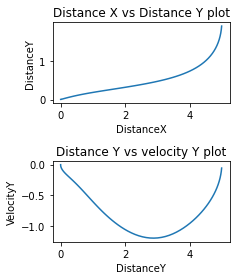

_______________________________________________________________________________________________________________

Iteration number:	 189
loss: 0.000


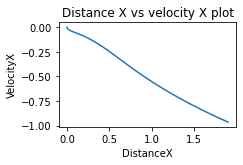

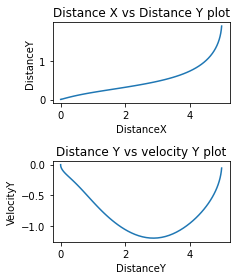

_______________________________________________________________________________________________________________

Iteration number:	 190
loss: 0.000


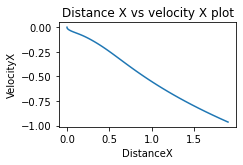

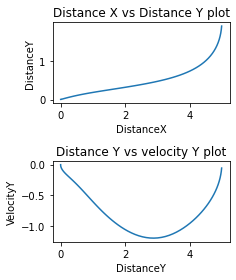

_______________________________________________________________________________________________________________

Iteration number:	 191
loss: 0.000


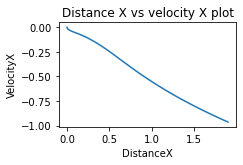

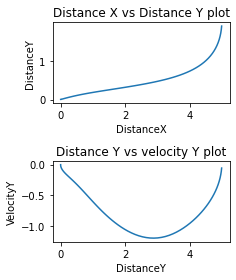

_______________________________________________________________________________________________________________

Iteration number:	 192
loss: 0.000


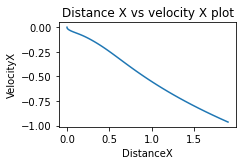

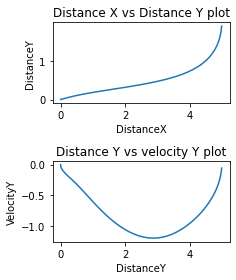

_______________________________________________________________________________________________________________

Iteration number:	 193
loss: 0.000


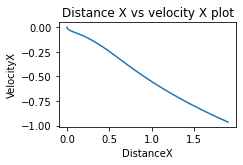

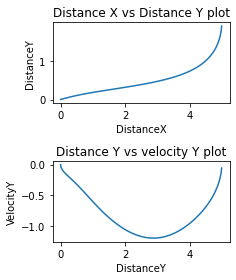

_______________________________________________________________________________________________________________

Iteration number:	 194
loss: 0.000


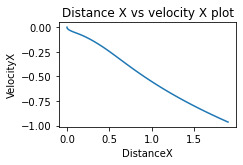

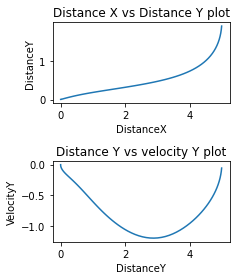

_______________________________________________________________________________________________________________

Iteration number:	 195
loss: 0.000


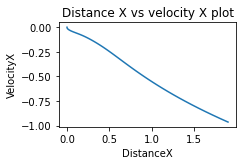

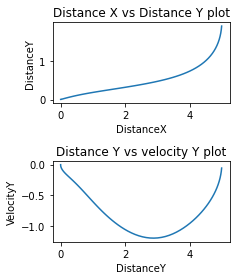

_______________________________________________________________________________________________________________

Iteration number:	 196
loss: 0.000


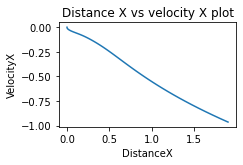

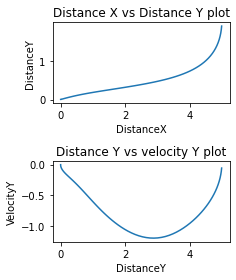

_______________________________________________________________________________________________________________

Iteration number:	 197
loss: 0.000


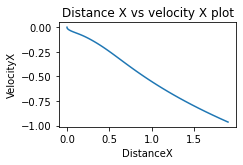

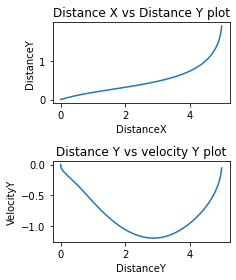

_______________________________________________________________________________________________________________

Iteration number:	 198
loss: 0.000


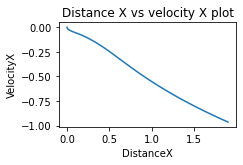

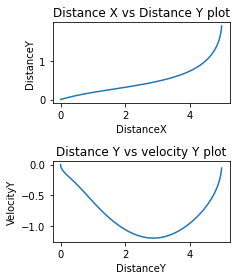

_______________________________________________________________________________________________________________

Iteration number:	 199
loss: 0.000


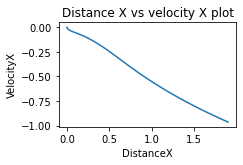

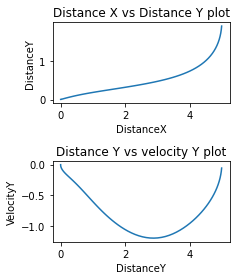

_______________________________________________________________________________________________________________

Iteration number:	 200
loss: 0.000


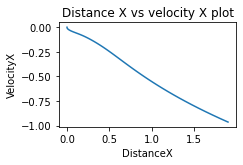

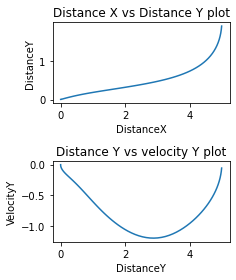

In [49]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(200)  # solve the optimization problem

# Conclusion: 

The above plotted graphs shows the optimization of a rocket landing with considering the state functions as the valocity of the rocket and the position in each direction in a coordinate space.

Velocity with respect to distance in each direction and the optimization between both the direction (i.e. X & Y) is calculated and the learning rate for this problem is taken as 0.07.

The loss function is the most optimized at 77th iteration.

From the first iteration to the 31st iteration, the convergence is extremely fast and there after is slows down till 59th iteration.

Considering all the assumptions and optimizing the objective function, one can say that the minimization of the function can be achieved at around 80 iterations with high accuracy.